In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mpldts
import calendar
import netCDF4

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
import tensorflow as tf
import scipy as sp
from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import sklearn.metrics
import numpy as np
import pandas as pd
import os
import matlab.engine
import scipy.io
import math
import pdb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import req_functions_modified
import importlib

plt.rcParams["font.family"] = "serif"   ## setting the font type for all the plots

In [3]:
##### Marks the start time for the start of the predictor-corrector model (23rd March, 2024 at 11:30 pm)
start_time = 2330
buoy_num = '076'

##### The slow varying amplitudes computed using the model predictions through the wave model are read here.
##### The initial model predictions are based on the WCSPH model simulations

slow_vars = pd.read_csv("SlowVaryingAmplitudes_Observations_23_30.csv", header = None)

##### The observations from the buoy for a 5 minute window at this time are read here.
observations = pd.read_csv('z_disp_23_30.txt', header = None)

len_observations = len(observations)
slow_var_arrays = np.asarray(slow_vars)
slow_var_window = slow_var_arrays[:,:len_observations]  ### part of the model predictions to be used for comparing to the observations 
X_req_23_30 = np.transpose(slow_var_window)
Y_req_23_30 = np.asarray(observations)

X_req = X_req_23_30   ###### x-data to be used for mapping to the buoy observations
Y_req = Y_req_23_30   ###### y-data to be used for the mapping (the observations)

np.savetxt("observation_data_X.csv", X_req, delimiter=",")
np.savetxt("observation_data_Y.csv", Y_req, delimiter=",")

In [4]:
### Marks the start time for the start of the predictor-corrector model (23rd March, 2024 at 11:30 pm)
start_time = 2330
buoy_num = '076'

### The slow varying amplitudes computed using the model predictions through the wave model are read here.
### The initial model predictions are based on the WCSPH model simulations
slow_vars = pd.read_csv("SlowVaryingAmplitudes_23_30.csv", header = None)
elevation = np.transpose(np.asarray(pd.read_csv('Model_prediction_23_30.csv', header = None)))

### The observations from the buoy for a 5 minute window at this time are read here.
observations = pd.read_csv('z_disp_23_30.txt', header = None)

mse_error_window = []
mae_error_window = []
corr_window = []
len_preds = len(elevation)
len_observations = len(observations)
for i in range(len_preds - len_observations + 1):
    obs = observations
    preds = elevation[i:len_observations+i]
    mse_error = mean_squared_error(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
    mae_error = mean_absolute_error(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
    corr = np.corrcoef(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
    corr_score = corr[0,1]
    mse_error_window.append(mse_error)
    mae_error_window.append(mae_error)
    corr_window.append(corr_score)

error_window = mse_error_window
if error_window == corr_window:
    error = max(error_window)
else:
    error = min(error_window)  
error_index = error_window.index(error)

slow_var_arrays = np.asarray(slow_vars)

### part of the model predictions to be used for comparing to the observations 
slow_var_window = slow_var_arrays[:,error_index:len_observations+error_index] 

X_req_23_30 = np.transpose(slow_var_window)
Y_req_23_30 = np.asarray(observations)

X_req = X_req_23_30   ### x-data to be used for mapping to the buoy observations
Y_req = Y_req_23_30   ### y-data to be used for the mapping (the observations)

np.savetxt("model_data_X.csv", X_req, delimiter=",")
np.savetxt("observation_data_Y.csv", Y_req, delimiter=",")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


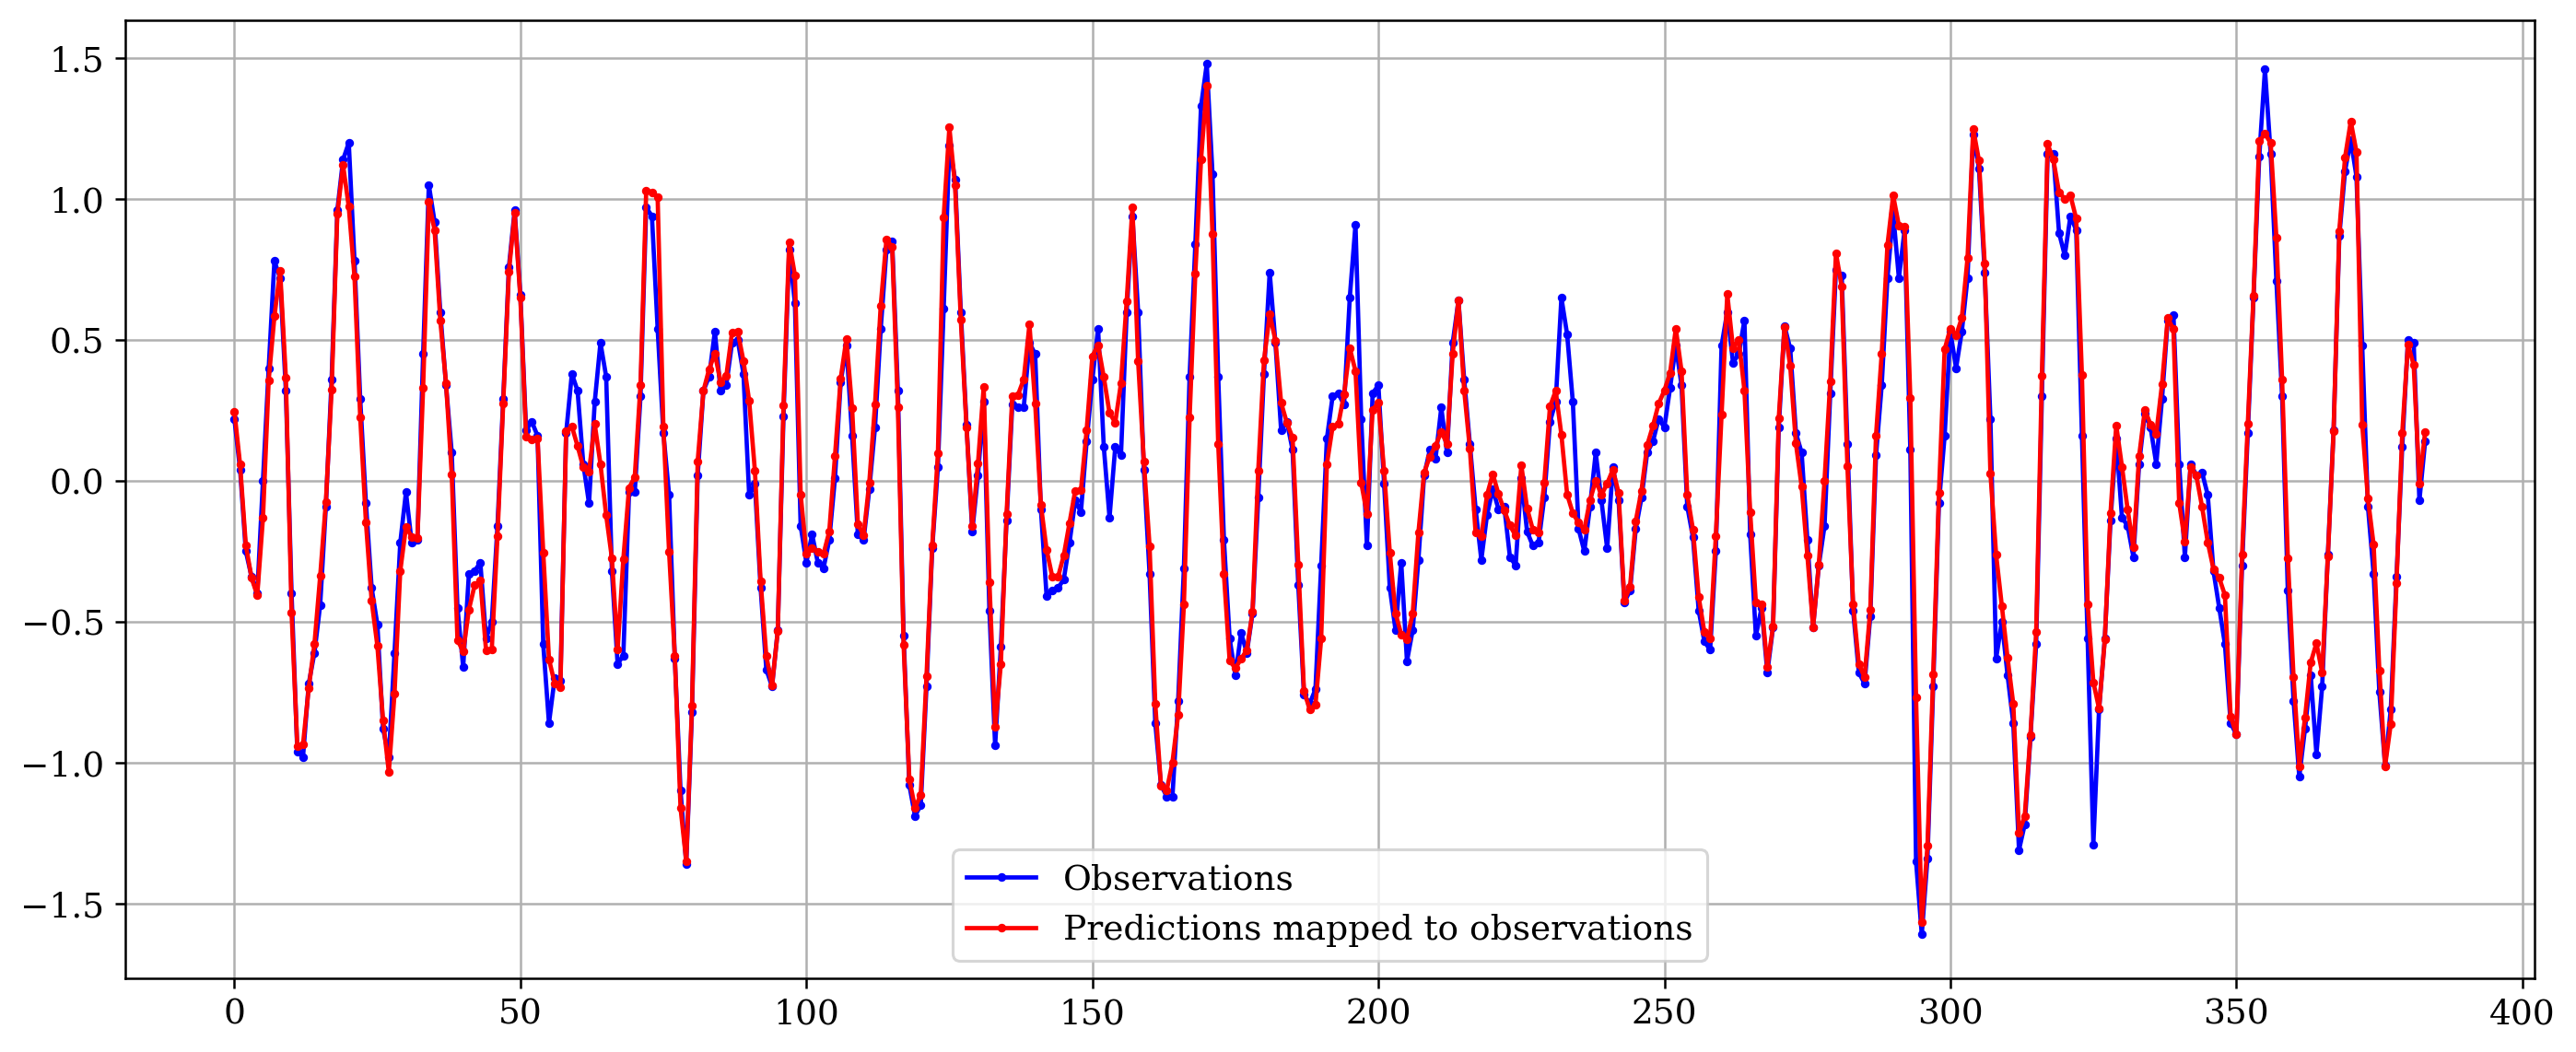

In [6]:
### Running the initial forecasts using the model predictions
slow_vars = np.asarray(pd.read_csv("model_data_X.csv", header = None))
observations = np.asarray(pd.read_csv("observation_data_Y.csv", header = None))

### The preprocessing of the model predictions and observations for mapping slow
### varying amplitudesfrom model predictions to the observations 
x_train_val, x_test, y_train_val, y_test = train_test_split(slow_vars, observations, random_state=0, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, test_size=0.3)

x_tv_scaler = MinMaxScaler()
x_tv_scaler.fit(x_train_val)
x_tv_scaled = x_tv_scaler.transform(x_train_val)
x_whole_scaled = x_tv_scaler.transform(slow_vars)
x_test_scaled = x_tv_scaler.transform(x_test)

y_tv_scaler = MinMaxScaler()
y_tv_scaler.fit(y_train_val)

### Using the trained MLP model to map the predictions to observations
file_str = '23_30'
file_save_name = 'D:/DiabloCanyon_WCSPH_Studies/mapping_/best_MLP_23_30_checkpoint.model.keras'
model = keras.models.load_model(file_save_name)

y_pred_scaled = model.predict(x_whole_scaled)
### The mapped results
y_pred = y_tv_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel().reshape(y_pred_scaled.shape[0],1)
np.savetxt("observations_mapped_window.csv", y_pred, delimiter = "," )

importlib.reload(req_functions_modified)
req_functions_modified.plot_reconstruction_observations(observations, y_pred, 12, "Observations","Predictions mapped to observations", start_time)

In [7]:
### start the matlab engine to access MATLAB from the python script and access results
eng = matlab.engine.start_matlab()

### parameters used for the time series model
train_len = 125  ### training length of the time s'eries model
omegas = np.asarray(pd.read_csv("Omegas_23_30_Observations.csv", header=None)).T  ### frequencies of observations computed using the wave model

In [ ]:
### Forecasting using the correction algorithm
### Incrementing the time till the required forecasting horizon
forecast_cumulative = []
observations_cumulative = []
forecast_horizon = 2336
while start_time < forecast_horizon:
    slow_amp_filename = eng.WaveFitFunc("observations_mapped_window.csv", train_len)
    mat_data = scipy.io.loadmat(slow_amp_filename)
    slow_amps_timeX = mat_data["slow_amps"]
#     print(slow_amps_timeX)

    ### CHECK OF THE PROCESS
    t_model, t_obs, ele_corrected_check  = req_functions.reconstructionElevation(slow_amps_timeX.T, omegas, 1, train_len)
    importlib.reload(req_functions)
    req_functions.plot_reconstruction_observations(observations[-train_len:],ele_corrected_check,12,"observations","reconstructed elevation",start_time)

    start_time += 5
    if start_time%100 >= 60:
        start_time += 40
    
    print(f"Time now is:{start_time}")
    
    if (start_time > forecast_horizon):
        break
    
    ### FORECASTING FOR THE NEXT WINDOW
    importlib.reload(req_functions)
    req_functions.time_series_model(train_len, slow_amps_timeX, x_tv_scaler)
        
    ### COMPARING THE FORECASTS AND THE OBSERVATIONS
    forecast_window = np.asarray(pd.read_csv(f"forecast_amps_next_window_train_len={train_len}", header=None))
    print(forecast_window.shape)
    t_model, t_obs, ele_corrected  = req_functions.reconstructionElevation(forecast_window.T, omegas, 1, train_len)
    
    forecast_cumulative.extend(ele_corrected) ### keeping track of the cumulative forecasts
    time_str = str(start_time)
    time = time_str[:2] + ":" + time_str[-2:]
    observations_new = req_functions.buoy_observations(buoy_num, time)
    observations_cumulative.extend(observations_new) ### keeping track of the cumulative observations
    req_functions.plot_reconstruction_observations(observations_new,ele_corrected,12,"observations","forecasted elevation", start_time)
    
    ### MAPPING THE PREDICTED AMPLITUDES FOR THE LAST PART OF THE OBSERVATION WINDOW
    req_window = forecast_window.T[-train_len:,:]
    req_observations = observations_new[-train_len:]
    x_tv_scaler.fit(req_window)
    x_tv_scaled = x_tv_scaler.transform(req_window)
    y_tv_scaler.fit(req_observations.reshape(-1,1))
    y_tv_scaled = y_tv_scaler.transform(req_observations.reshape(-1,1))
    
    ### FITTING THE MODEL ON THE EXTRACTED DATA USING CHOSEN HYPERPARAMETERS
    model_MLP = req_functions.create_model(x_tv_scaled, hidden_layer_sizes=(400, 600, 800), optimizer='adam')
    model_MLP.fit(x_tv_scaled, y_tv_scaled, epochs=1000, batch_size=64, verbose=0)

    ### GETTING THE FIT ON THE OBSERVATIONS
    y_pred_scaled = model_MLP.predict(x_tv_scaled)
    y_pred = y_tv_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    y_true = y_tv_scaler.inverse_transform(y_tv_scaled.reshape(-1,1)).ravel()
    req_functions.MLP_mapping_results(y_true, y_pred)
    np.savetxt("observations_mapped_window.csv", y_pred, delimiter = "," )
    observations = y_pred


errors_cumulative = abs(np.asarray(observations_cumulative) - np.asarray(forecast_cumulative))
np.savetxt("observations_full_duration.csv", observations_cumulative, delimiter = "," )
np.savetxt("predictions_full_duration.csv", forecast_cumulative, delimiter = "," )
np.savetxt("errors_full_duration.csv", errors_cumulative, delimiter = "," )
importlib.reload(req_functions)
req_functions.plot_complete_duration(observations_cumulative,forecast_cumulative,12,"observations","predictions")

768
Nf:16
Forecasting done for the next observation window
Nf:16
Time now is:2335
Time now is:2340
Time now is:2345


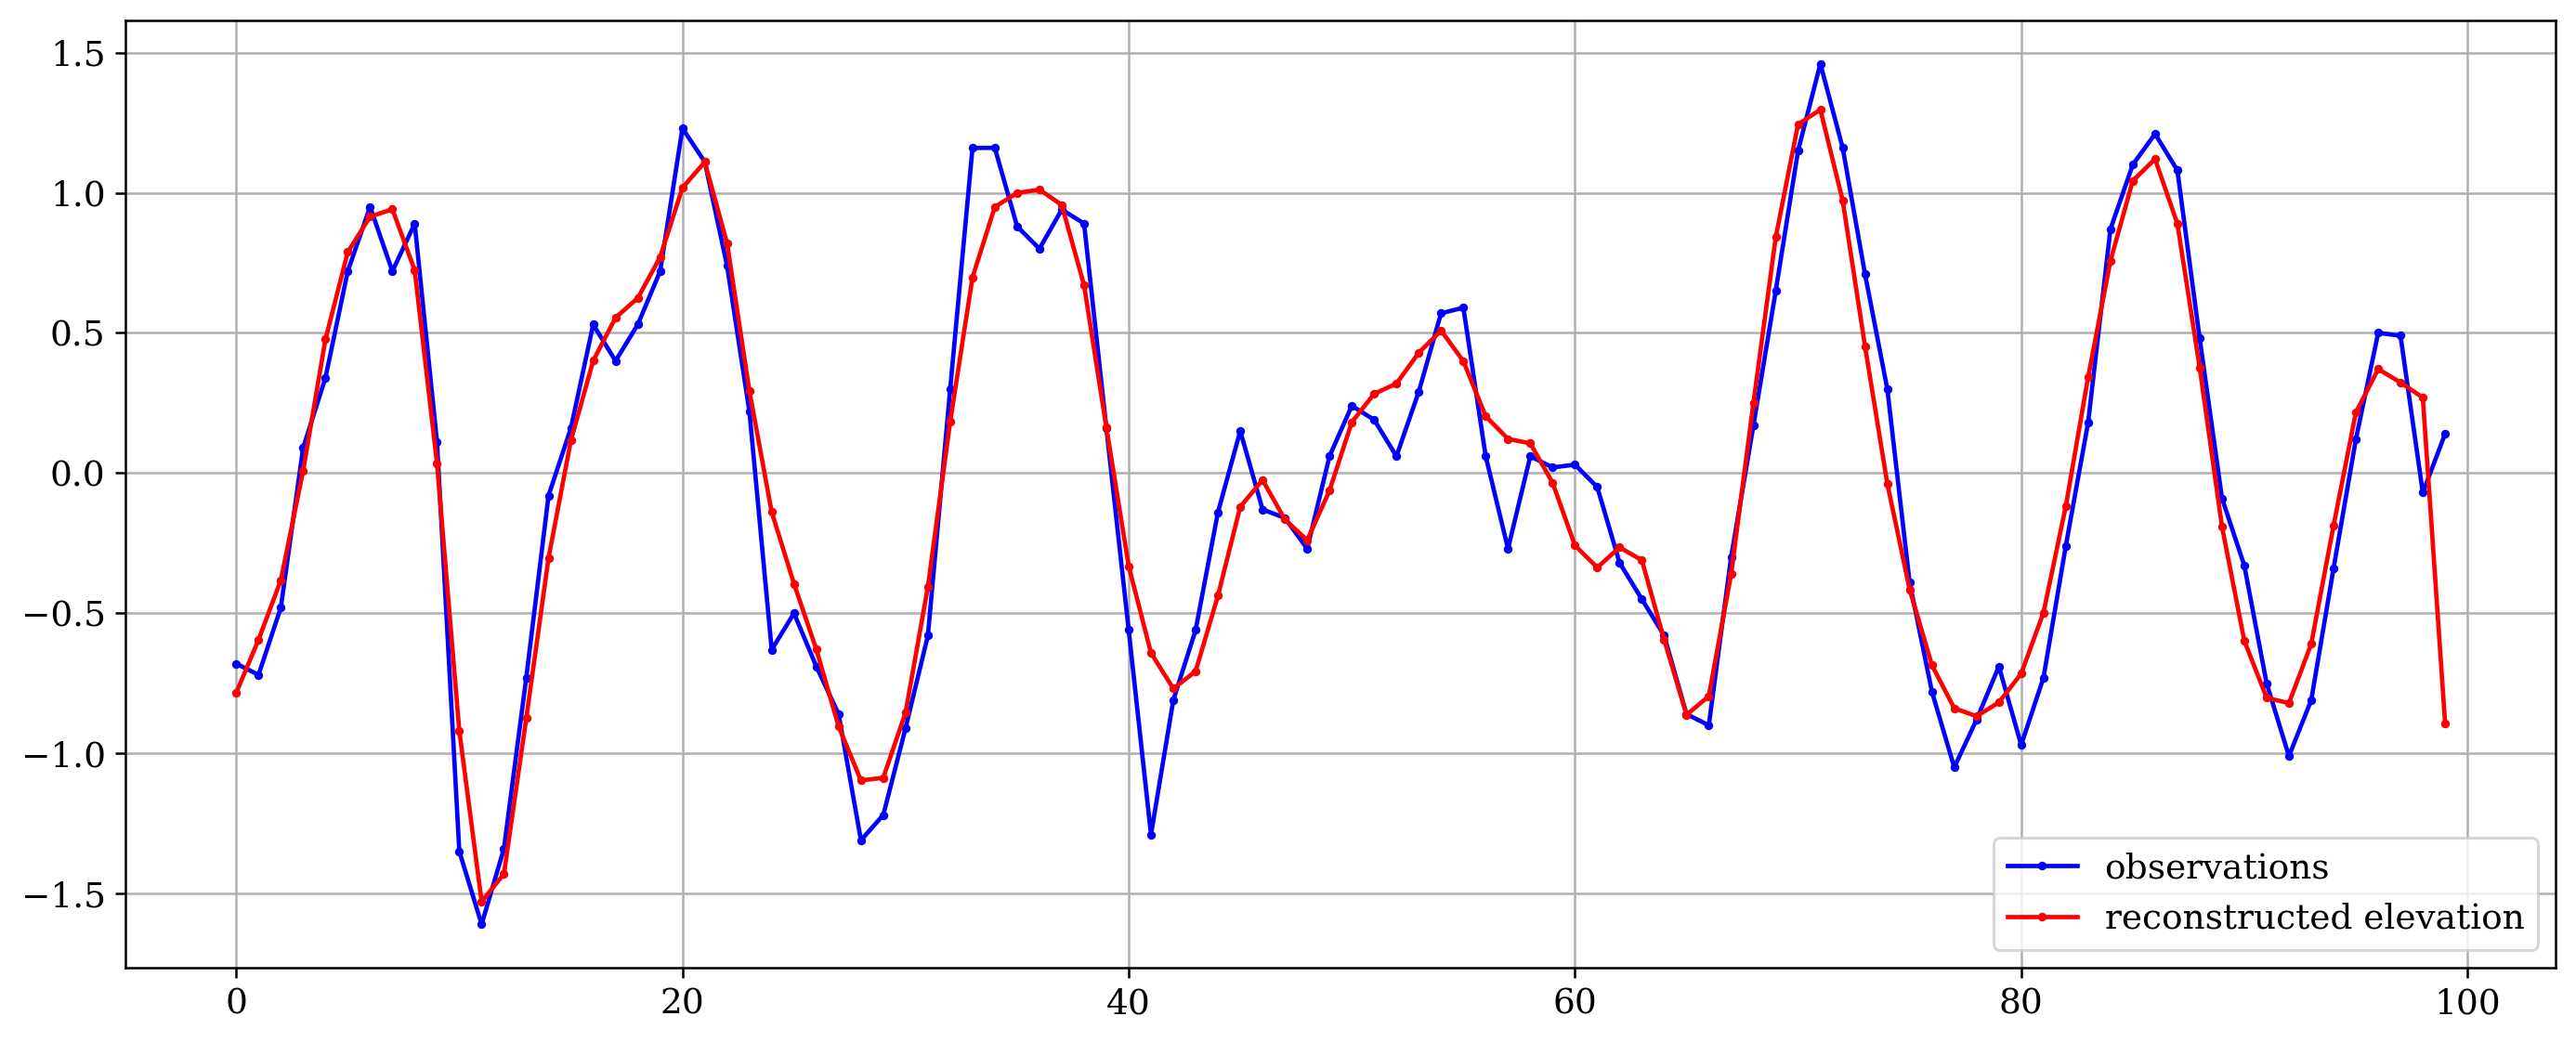

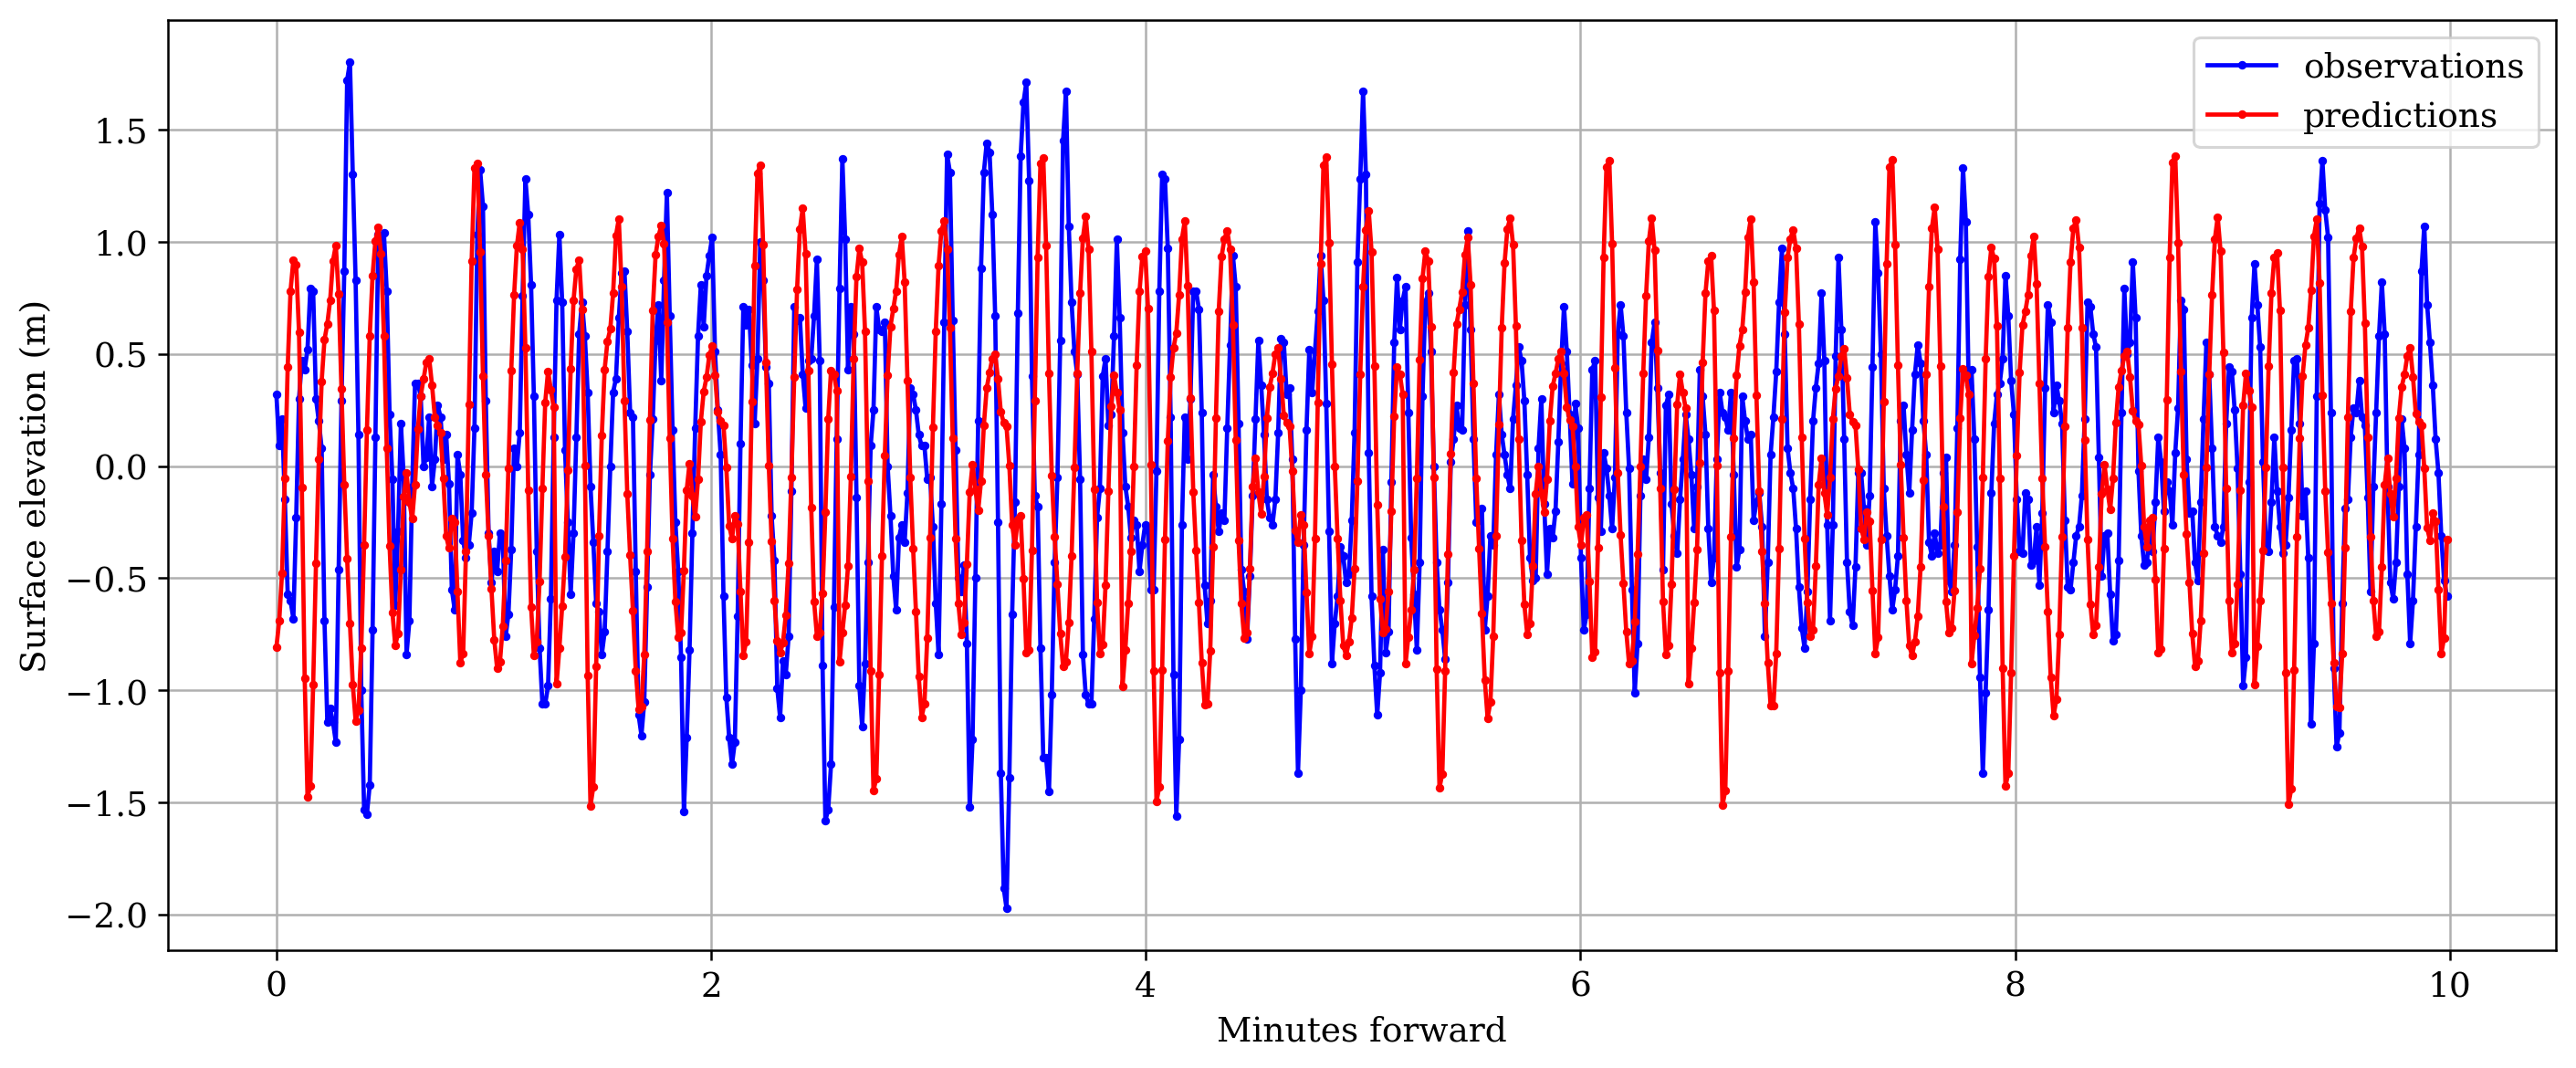

Forecasting done for the next observation window
Nf:16
Time now is:2335
Time now is:2340
Time now is:2345


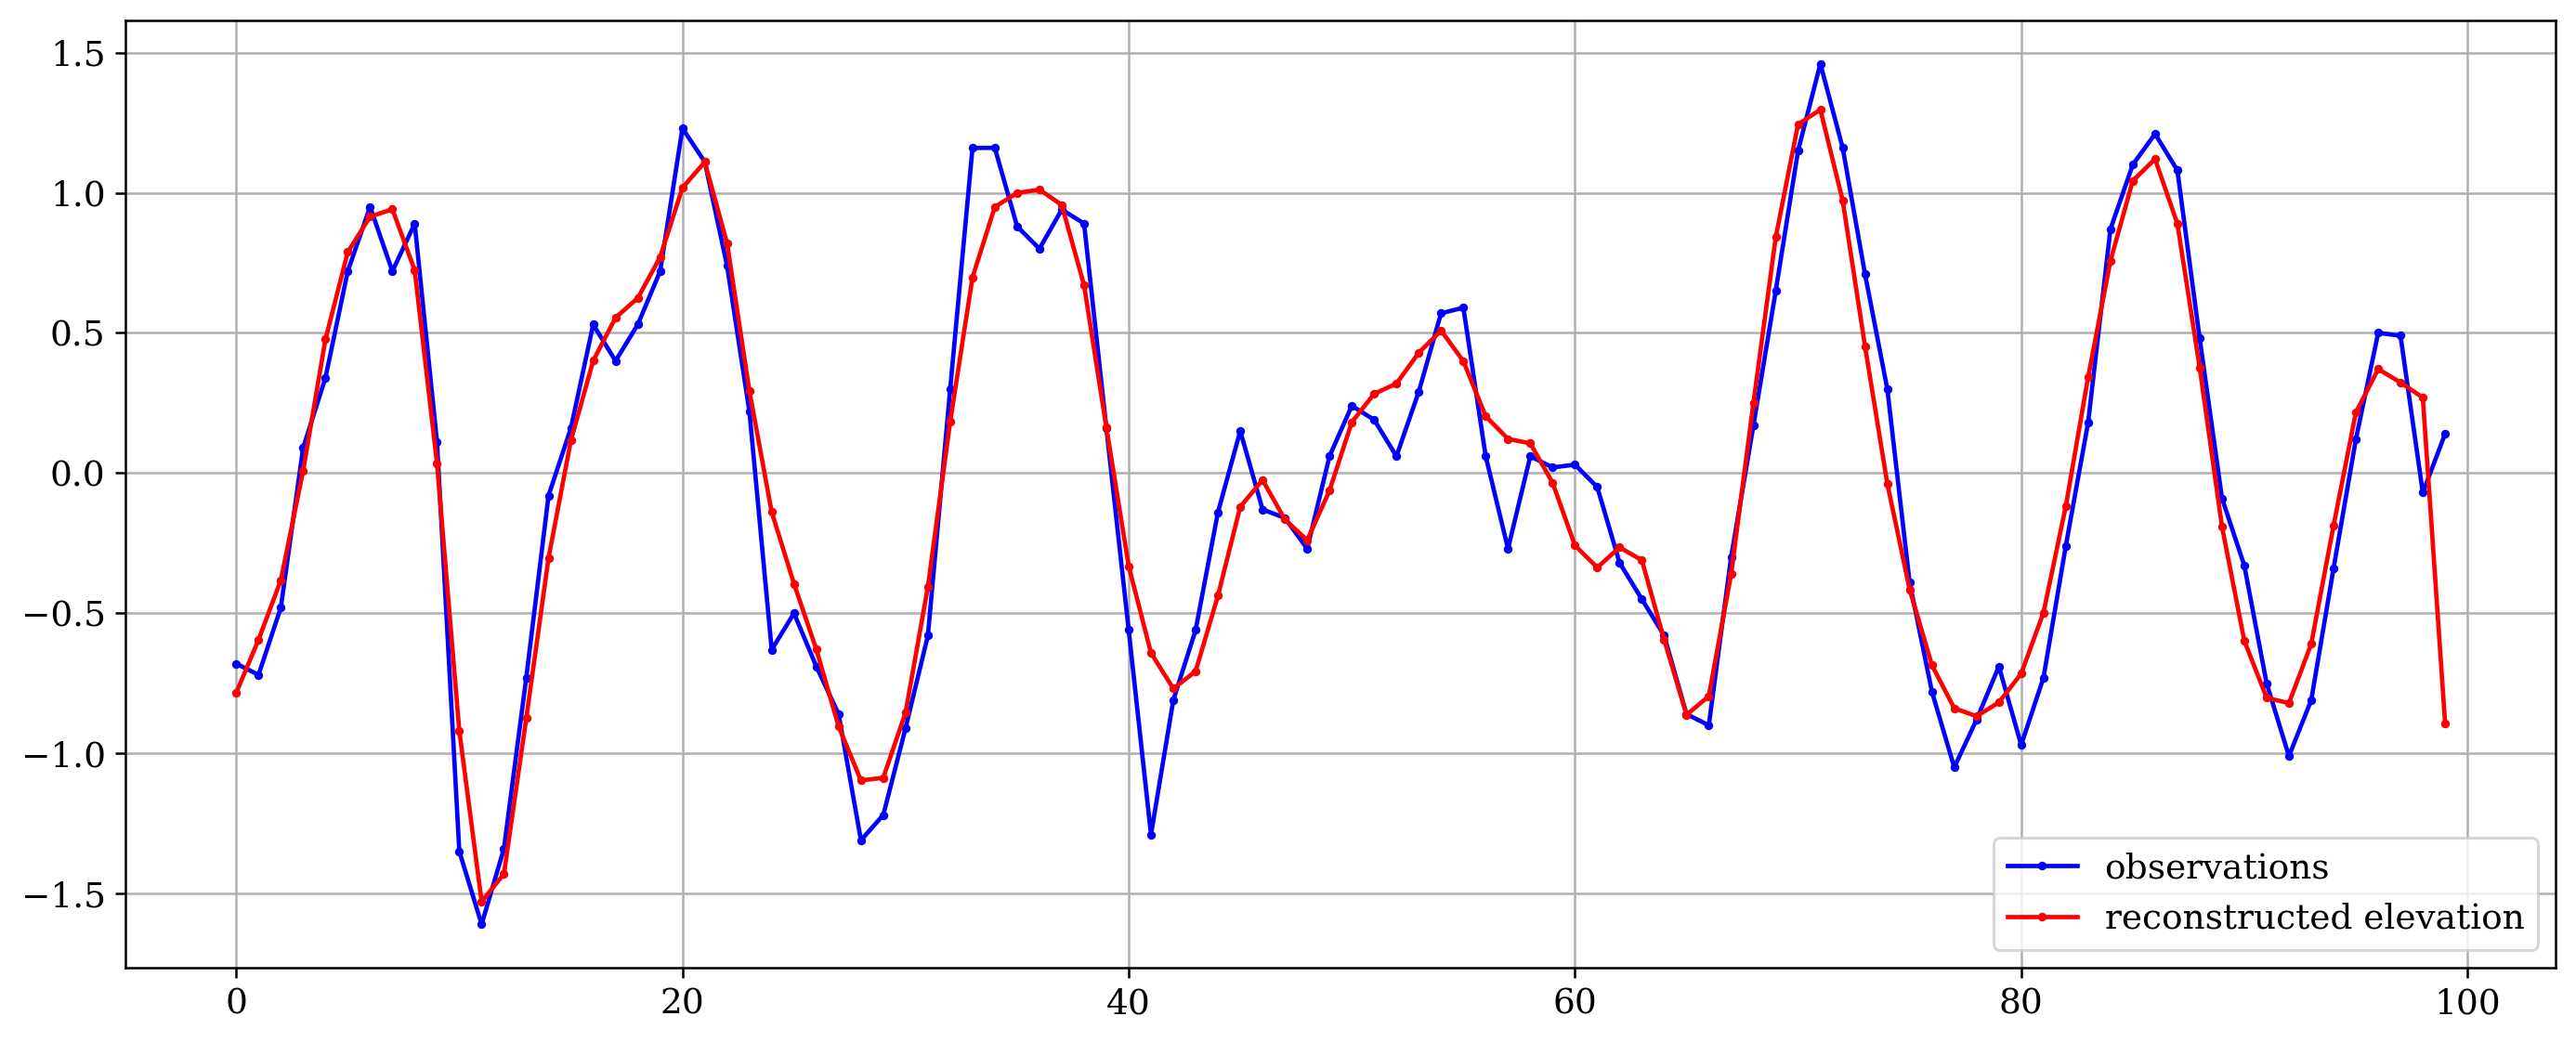

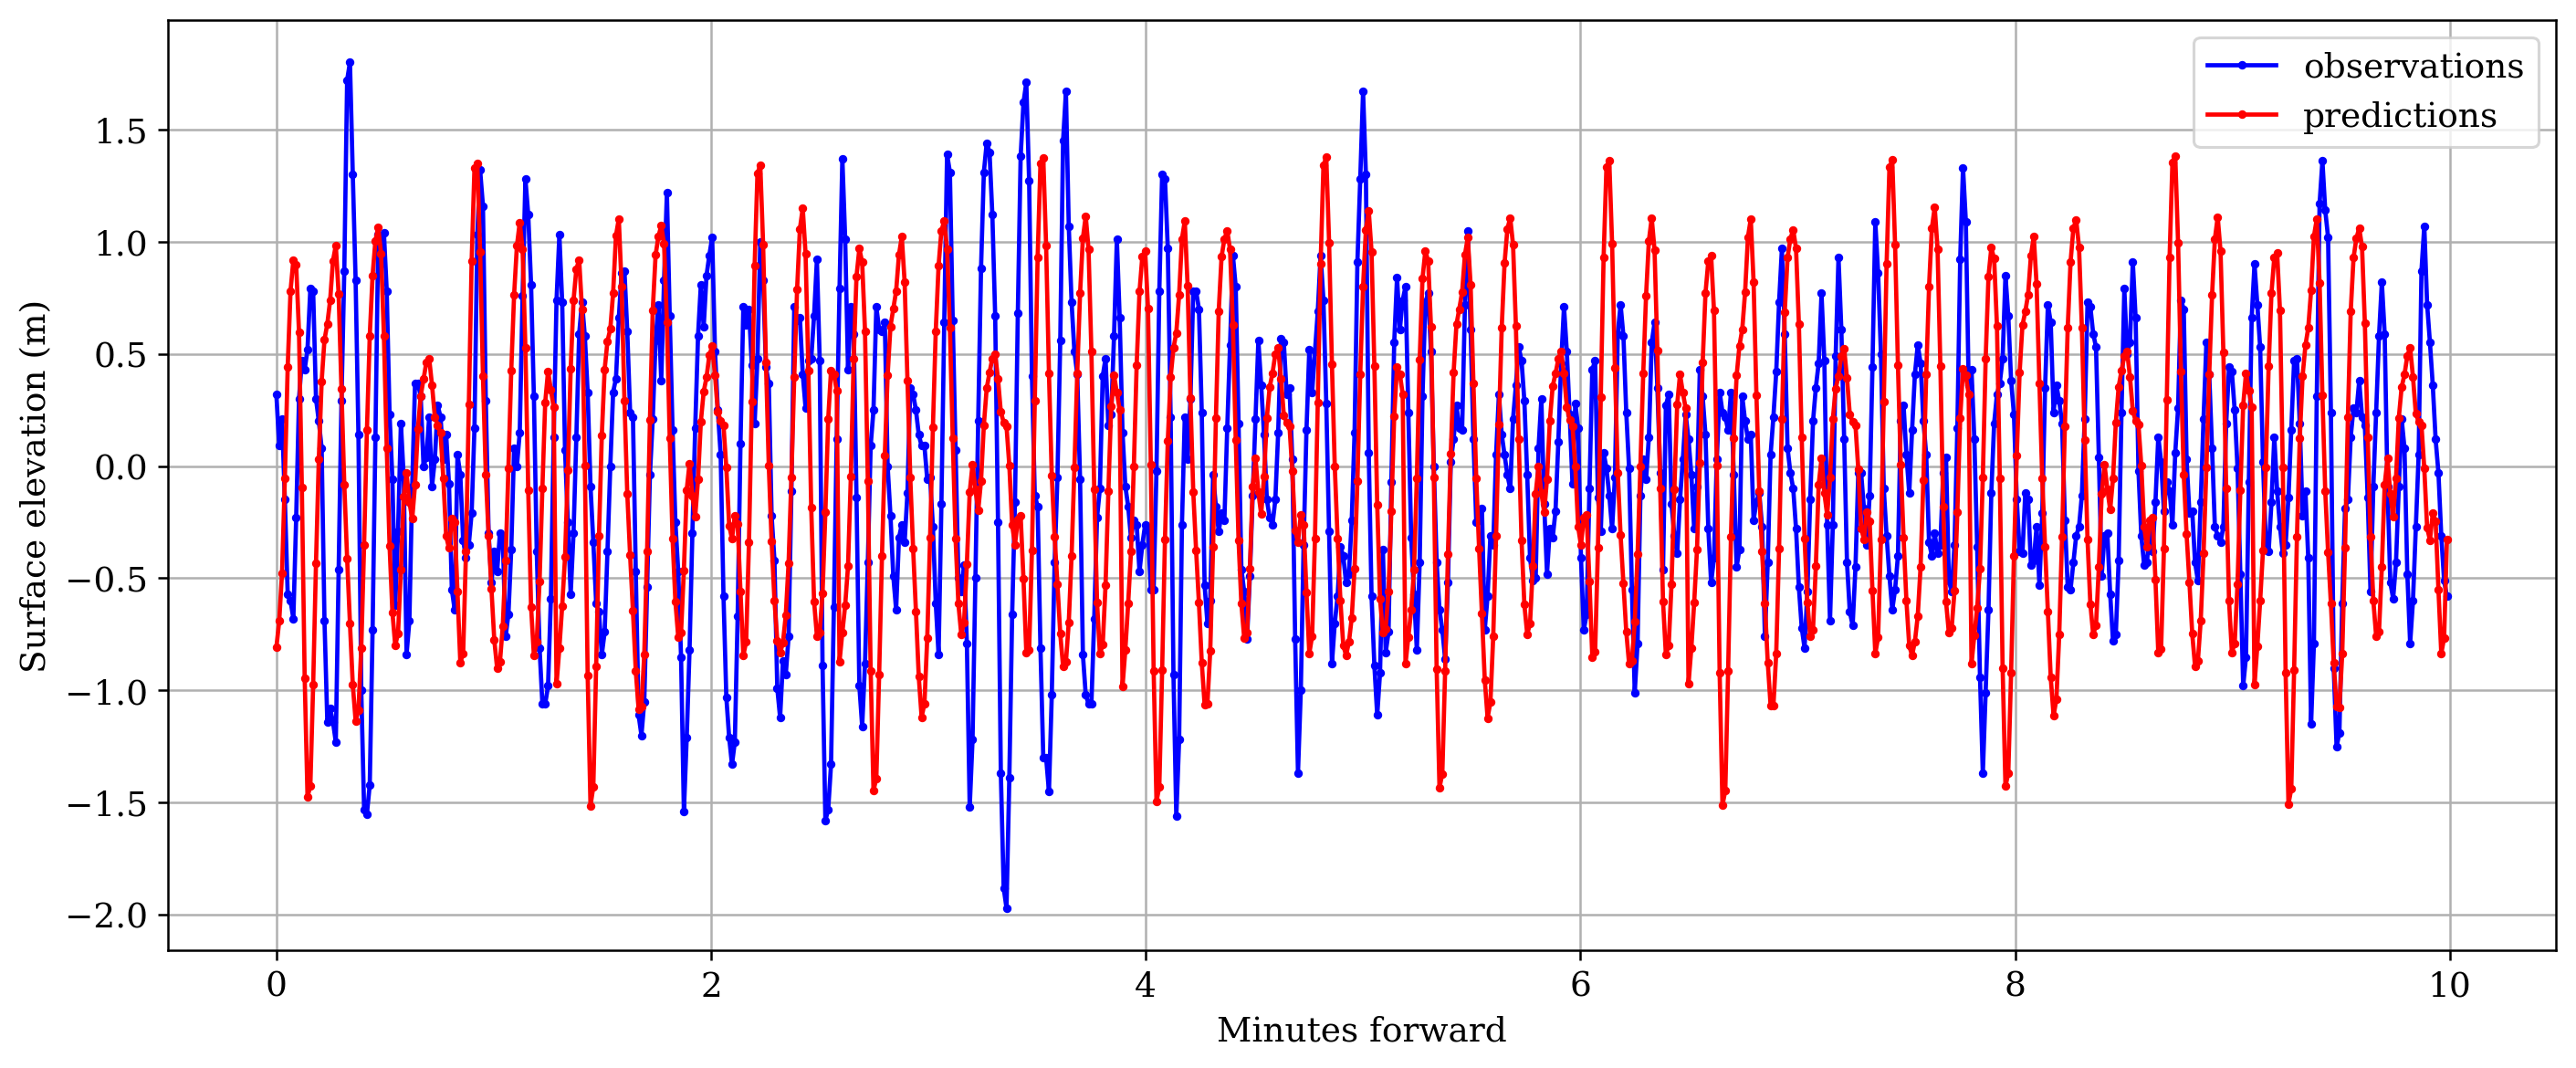

In [6]:
### Forecasting only using the time series model
### Forecasting part

### number of forecast steps
samplerate = 1.28
minutes = 10
forecast_len = int(samplerate * minutes * 60)
print(forecast_len)
forecast_cumulative = []

slow_amp_filename = eng.WaveFitFunc("observations_mapped_window.csv", train_len)
mat_data = scipy.io.loadmat(slow_amp_filename)
slow_amps_timeX = mat_data["slow_amps"]

### CHECK OF THE PROCESS
t_model, t_obs, ele_corrected_check = req_functions.reconstructionElevation(slow_amps_timeX.T, omegas, 1, train_len)
importlib.reload(req_functions)
req_functions.plot_reconstruction_observations(observations[-train_len:],ele_corrected_check,12,"observations","reconstructed elevation",start_time)

### FORECASTING FOR THE ENTIRE FORECASTING HORIZON
importlib.reload(req_functions)
req_functions.time_series_model_only(train_len, forecast_len, slow_amps_timeX, x_tv_scaler)
forecast_window = np.asarray(pd.read_csv(f"forecast_amps_next_window_train_len={train_len}_forecast_len={forecast_len}", header=None))
t_model, t_obs, ele_corrected  = req_functions.reconstructionElevation(forecast_window.T, omegas, 1, train_len)
forecast_cumulative.extend(ele_corrected) ### keeping track of the cumulative forecasts

### OBSERVATIONS FOR THE ENTIRE FORECASTING HORIZON
observations_cumulative = []
forecast_horizon = 2341
while start_time < forecast_horizon:
    start_time += 5
    if start_time%100 >= 60:
        start_time -= 2360
    
    print(f"Time now is:{start_time}")
    
    if (start_time > forecast_horizon):
        break
        
    time_str = str(start_time)
    time = time_str[:2] + ":" + time_str[-2:]
    observations_new = req_functions.buoy_observations(buoy_num, time)
    observations_cumulative.extend(observations_new) ### keeping track of the cumulative observations
    
errors_cumulative = abs(np.asarray(observations_cumulative) - np.asarray(forecast_cumulative))
np.savetxt("observations_full_duration.csv", observations_cumulative, delimiter = "," )
np.savetxt("predictions_full_duration.csv", forecast_cumulative, delimiter = "," )
np.savetxt("errors_full_duration.csv", errors_cumulative, delimiter = "," )
importlib.reload(req_functions)
req_functions.plot_complete_duration(observations_cumulative,forecast_cumulative,12,"observations","predictions")